MUR to Zarr using harmony service 
===========================
### Author: Edward Armstrong 
#### 2022-10-01

### Objective

Use NASA harmony-netcdf-to-zarr service to convert individual netCDF granules to a Zarr output on AWS-west 


### Input datasets

1. MUR SST
2. MUR25 SST
3. .....any gridded netCDF dataset

### Services and software used

1. NASA harmony-netcdf-to-Zarr
1. xarray, requests, json, pandas, numpy, matplotlib, **s3fs**
1. Various python utlities including the NASA harmony-py package

# Import various libraries

In [1]:
from matplotlib import pylab as plt
import xarray as xr
import numpy as np
import pandas as pd
import requests
import json
import time
import s3fs
import re

from datetime import datetime
from harmony import Client, Collection, Environment, Request

# Set the ShortName of the dataset of interest

The shortname is an unique pointer for each NASA dataset. 

In [2]:
ShortName = "MUR25-JPL-L4-GLOB-v04.2"
#ShortName = "MUR-JPL-L4-GLOB-v4.1"

## Set start and end dates


In [3]:
# Set time bounds
start_year = 2020
start_month = 12
start_day = 1

end_year = 2020
end_month = 12
end_day = 31

# Find the concept_id

In [4]:
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]

ccid = ummc['meta']['concept-id']

ccid

'C2036880657-POCLOUD'

# Perform the netCDF to Zarr transformation
## Setup the harmony-py service call and execute a request

In [5]:
# using the the harmony.py service, set up the request and execute it
ecco_collection = Collection(id=ccid)
time_range = {'start': datetime(start_year, start_month, start_day), 'stop': datetime(end_year, end_month, end_day)}
print(time_range)

harmony_client = Client(env=Environment.PROD)

# in this example set concatentae to 'True' since the time steps are exactly equal
ecco_request = Request(collection=ecco_collection, temporal=time_range, format='application/x-zarr', concatenate='True')

# sumbit request and monitor job
ecco_job_id = harmony_client.submit(ecco_request)
print('\n Waiting for the job to finish. . .\n')
ecco_response = harmony_client.result_json(ecco_job_id, show_progress=True)
print("\n. . .DONE!")

{'start': datetime.datetime(2020, 12, 1, 0, 0), 'stop': datetime.datetime(2020, 12, 31, 0, 0)}

 Waiting for the job to finish. . .



 [ Processing: 100% ] |###################################################| [|]



. . .DONE!


#  Print some AWS info

In [6]:
print(ecco_response['message'])
with requests.get(ecco_response['links'][2]['href']) as r:
    creds = r.json()

print( creds.keys() )
print("AWS credentials expire on: ", creds['Expiration'] )

The job has completed successfully. Contains results in AWS S3. Access from AWS us-west-2 with keys from https://harmony.earthdata.nasa.gov/cloud-access.sh
dict_keys(['AccessKeyId', 'SecretAccessKey', 'SessionToken', 'Expiration'])
AWS credentials expire on:  2022-10-05T07:26:20.000Z


# List AWS zarr dataset created above with s3fs 

In [10]:
s3_dir = ecco_response['links'][3]['href']

print("root directory:", s3_dir)

s3_urls = [u['href'] for u in ecco_response['links'][4:-1]]

# sort the URLs in time order
s3_urls.sort()

print(s3_urls)

s3 = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)

len(s3.ls(s3_dir))

root directory: s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4aaab55a-9604-49a6-8552-61054e252507/
['s3://harmony-prod-staging/public/harmony/netcdf-to-zarr/4aaab55a-9604-49a6-8552-61054e252507/C2036880657-POCLOUD_merged.zarr']


1

# Open dataset with xarray()

In [18]:
ds = xr.open_zarr(s3.get_mapper(s3_urls[0]), decode_cf=True, mask_and_scale=True)
ds

<xarray.Dataset>
Dimensions:           (time: 31, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2020-12-01T09:00:00 ... 2020-12-3...
Data variables:
    analysed_sst      (time, lat, lon) float64 dask.array<chunksize=(31, 251, 251), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 dask.array<chunksize=(31, 251, 251), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(31, 712, 712), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 dask.array<chunksize=(31, 251, 251), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 dask.array<chunksize=(31, 251, 251), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_institution:        Jet Propulsion Laboratory
    ...                         ...
    time_coverage_end:          20201204T210000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20201203T210000Z
    title:                      Daily 0.25-degree MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

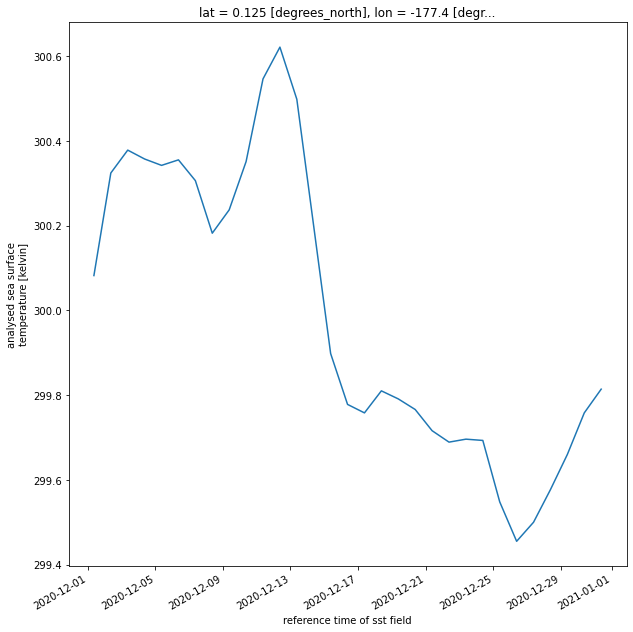

In [36]:
# Do some plotting
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
ds.analysed_sst.isel(lon=10, lat=360).plot.line(x="time")